#### Imports and Load env variables

In [4]:
import os
import requests
import json
import pathlib
from bs4 import BeautifulSoup
import re
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel
from pydantic import Field
from typing import List, Dict, Any
from typing import Literal
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.schema import HumanMessage, AIMessage
from __future__ import print_function
import sib_api_v3_sdk
from sib_api_v3_sdk.rest import ApiException
from IPython.display import Markdown, display

In [5]:
from dotenv import load_dotenv
load_dotenv()

True

#### Perform google search with Serper and Define relevance

In [6]:
search_terms = ["Agentic AI", "OpenAI", "AI Agents LinkedIn", "Agentic AI Enterprise"]

In [7]:
class ResultRelevance(BaseModel):
    explanation: str
    id: str

class RelevanceCheckOutput(BaseModel):
    relevant_results: List[ResultRelevance]

def search_serper(search_query):
    """
    Calls Serper's Google Search API and 
    """
    url = "https://google.serper.dev/search"
    
    payload = json.dumps({
        "q": search_query,
        "gl": "gb", 
        "num": 30,
        "tbs": "qdr:d"
    })

    headers = {
        'X-API-KEY': os.environ["SERPER_API_KEY"],
        'Content-Type': 'application/json'
    }

    response = requests.request("POST", url, headers=headers, data=payload)
    results = json.loads(response.text)
    results_list = results['organic']

    all_results = []
    for id, result in enumerate(results_list, 1):
        result_dict = {
            'title': result['title'],
            'link': result['link'],
            'snippet': result['snippet'],
            'search_term': search_query,
            'id': id
        }
        all_results.append(result_dict)
    return all_results


def load_prompt(prompt_name):
    with open(f"prompts/{prompt_name}.md", "r") as file:
        return file.read()


def check_search_relevance(search_results: Dict[str, Any]) -> RelevanceCheckOutput:
    """
    Analyze search results and determine the most relevant ones.
    
    Args:
        search_results: Dictionary containing search results to analyze
        
    Returns:
        RelevanceCheckOutput containing the most relevant results and explanation
    """
    prompt = load_prompt("relevance")
    
    prompt_template = ChatPromptTemplate.from_messages([
        ("system", prompt)
    ])

    llm = ChatOpenAI(model="gpt-4o", max_tokens=300).with_structured_output(RelevanceCheckOutput)
    llm_chain = prompt_template | llm
    
    return llm_chain.invoke({'input_search_results': search_results})



relevant_results = []
for search_term in search_terms:
    python_results = search_serper(search_term)
    results = check_search_relevance(python_results)
    
    # Get the relevant result IDs from the LLM output
    relevant_ids = [r.id for r in results.relevant_results]
    
    # Filter original results to only include those with matching IDs
    filtered_results = [r for r in python_results if str(r['id']) in relevant_ids]
    
    relevant_results.extend(filtered_results)

In [8]:
relevant_results

[{'title': 'What is agentic AI and why is everyone talking about it? - Mashable',
  'link': 'https://mashable.com/article/agentic-ai-explainer',
  'snippet': 'Agentic AI refers to a class of artificial intelligence systems designed to operate autonomously, perceive their environment, set goals, plan actions to ...',
  'search_term': 'Agentic AI',
  'id': 3},
 {'title': 'Box CTO on Agentic AI: Beyond the Black Box of Pure LLMs',
  'link': 'https://www.startuphub.ai/ai-news/ai-video/2025/box-cto-on-agentic-ai-beyond-the-black-box-of-pure-llms/',
  'snippet': 'Box CTO Ben Kus details the transition to an agentic AI architecture, overcoming pure LLM limitations for enterprise unstructured data with enhanced ...',
  'search_term': 'Agentic AI',
  'id': 6},
 {'title': 'Eduardo Ordax - ai #agents #agentic - LinkedIn',
  'link': 'https://www.linkedin.com/posts/eordax_ai-agents-agentic-activity-7365340696301527041-ALfu',
  'snippet': 'Agentic AI Overview (Stanford): https://lnkd.in/gk4GKdxa 4. 

#### Scrape data from HTML and convert to markdown

In [9]:
def convert_html_to_markdown(html_content: str) -> str:
    soup = BeautifulSoup(html_content, 'html.parser')

    # paragraphs & line breaks
    for br in soup.find_all('br'):
        br.replace_with('\n')
    for p in soup.find_all('p'):
        p.insert_before('\n')
        p.insert_after('\n')

    # headers
    for h in soup.find_all(['h1','h2','h3','h4','h5','h6']):
        level = int(h.name[1])
        h.replace_with('#'*level + ' ' + h.get_text(strip=True) + '\n\n')

    # bold/italic
    for b in soup.find_all(['b','strong']):
        b.replace_with(f"**{b.get_text()}**")
    for i in soup.find_all(['i','em']):
        i.replace_with(f"*{i.get_text()}*")

    # links
    for a in soup.find_all('a'):
        href = a.get('href') or ''
        text = a.get_text(strip=True)
        a.replace_with(f'[{text}]({href})' if (href and text) else text)

    # unordered lists
    for ul in soup.find_all('ul'):
        lines = []
        for li in ul.find_all('li', recursive=False):
            lines.append(f"- {li.get_text(strip=True)}")
        ul.replace_with('\n'.join(lines) + '\n')

    # ordered lists
    for ol in soup.find_all('ol'):
        lines = []
        for idx, li in enumerate(ol.find_all('li', recursive=False), 1):
            lines.append(f"{idx}. {li.get_text(strip=True)}")
        ol.replace_with('\n'.join(lines) + '\n')

    text = soup.get_text()
    text = re.sub(r'\n{3,}', '\n\n', text).strip()
    return text

In [10]:

# def scrape_and_save_markdown(relevant_results):
#     """
#     Scrapes HTML content from URLs in relevant_results and saves as markdown files.
    
#     Args:
#         relevant_results: List of dictionaries containing search results with URLs
        
#     Returns:
#         List of dictionaries containing markdown content and metadata
#     """
#     # Create scraped_html directory if it doesn't exist
#     pathlib.Path("scraped_markdown").mkdir(exist_ok=True)

#     markdown_contents = []
#     for result in relevant_results:
#         if 'link' in result:
#             params = {
#                 "api_key": os.environ.get("SCRAPING_API_KEY"), 
#                 "url": result['link'],
#                 "render_js": "true"
#             }

#             response = requests.get("https://scraping.narf.ai/api/v1/", params=params)
            
#             if response.status_code == 200:
#                 # Create filename from ID or URL if ID not available
#                 filename = f"{result.get('id', hash(result['link']))}.md"
#                 filepath = os.path.join("scraped_markdown", filename)
                
#                 # Convert HTML to markdown
#                 markdown_content = convert_html_to_markdown(response.content.decode())
                
#                 # Save markdown content to file
#                 with open(filepath, 'w', encoding='utf-8') as f:
#                     f.write(markdown_content)
                
#                 markdown_contents.append({
#                     'url': result['link'],
#                     'filepath': filepath,
#                     'markdown': markdown_content,
#                     'title': result.get('title', ''),
#                     'id': result.get('id', '')
#                 })
#             else:
#                 print(f"Failed to fetch {result['link']}: Status code {response.status_code}")

#     print(f"Successfully downloaded and saved {len(markdown_contents)} pages as markdown to scraped_markdown/")
#     return markdown_contents

# markdown_contents = scrape_and_save_markdown(relevant_results)

In [11]:
import hashlib

class RelevantResult(TypedDict, total=False):
    id: int | str
    title: str
    link: str
    snippet: str
    search_term: str
    
def scrape_and_save_markdown(relevant_results: List[RelevantResult]) -> List[Dict[str, Any]]:
    out_dir = pathlib.Path("scraped_markdown")
    out_dir.mkdir(exist_ok=True)

    api_key = os.environ.get("SCRAPING_API_KEY")  # set this in your env
    markdown_contents: List[Dict[str, Any]] = []

    for result in relevant_results:
        url = result.get('link')
        if not url:
            continue

        params = {"api_key": api_key, "url": url, "render_js": "true"}
        try:
            resp = requests.get("https://scraping.narf.ai/api/v1/", params=params, timeout=30)
            resp.raise_for_status()
        except requests.RequestException as e:
            print(f"Failed to fetch {url}: {e}")
            continue

        # choose encoding safely
        content = resp.text

        md = convert_html_to_markdown(content)

        # stable filename
        rid = str(result.get('id', ''))
        if rid == '':
            rid = hashlib.sha1(url.encode('utf-8')).hexdigest()[:12]
        filename = f"{rid}.md"
        filepath = out_dir / filename

        filepath.write_text(md, encoding='utf-8')

        markdown_contents.append({
            "url": url,
            "filepath": str(filepath),
            "markdown": md,
            "title": result.get("title", ""),
            "id": result.get("id", "")
        })

    print(f"Successfully saved {len(markdown_contents)} pages to {out_dir}/")
    return markdown_contents

In [12]:
markdown_contents = scrape_and_save_markdown(relevant_results)

Successfully saved 20 pages to scraped_markdown/


In [13]:
markdown_contents

[{'url': 'https://mashable.com/article/agentic-ai-explainer',
  'filepath': 'scraped_markdown\\3.md',
  'markdown': 'Agentic AI: What is it and why are people talking about it? | Mashable\n\n \n\n[Creator Hub](https://mashable.com/category/creators)\n[Tech](https://mashable.com/tech)\n[Science](https://mashable.com/science)\n[Life](https://mashable.com/life)\n[Social Good](https://mashable.com/category/social-good)\n[Entertainment](https://mashable.com/entertainment)\n[Deals](https://mashable.com/deals)\n[Shopping](https://mashable.com/shopping)\n[Games](https://games.mashable.com/)\n\nSearch\n\nCancel\n\n- \n\n[Creator Hub](https://mashable.com/category/creators)\n\nTech\n\n[Apps & Software](https://mashable.com/category/apps-software)\n[Artificial Intelligence](https://mashable.com/category/artificial-intelligence)\n[Cybersecurity](https://mashable.com/category/cybersecurity)\n[Cryptocurrency](https://mashable.com/category/cryptocurrency)\n[Mobile](https://mashable.com/category/mobil

#### Generate Summaries of Markdown

In [14]:
def generate_summaries(markdown_contents):
    """
    Generates summaries for markdown content using GPT-4.
    
    Args:
        markdown_contents: List of dictionaries containing markdown content and metadata
        
    Returns:
        List of dictionaries containing summaries and URLs
    """
    # Create markdown_summaries directory if it doesn't exist
    pathlib.Path("markdown_summaries").mkdir(exist_ok=True)

    # Load the summary prompt
    summary_prompt = load_prompt("sum_markdown")

    # Create prompt template
    summary_template = ChatPromptTemplate.from_messages([
        ("system", summary_prompt)
    ])

    # Initialize LLM
    llm = ChatOpenAI(model="gpt-4o",temperature=0.4)
    summary_chain = summary_template | llm

    # Generate and save summaries
    summaries = []
    for content in markdown_contents:
        try:
            # Generate summary, limiting to first 2000 words
            summary = summary_chain.invoke({
                'markdown_input': ' '.join(content['markdown'].split()[:2000])
            })
            
            # Create filename for summary
            summary_filename = f"summary_{content['id']}.md"
            summary_filepath = os.path.join("markdown_summaries", summary_filename)
            
            # Save summary to file
            with open(summary_filepath, 'w', encoding='utf-8') as f:
                f.write(summary.content)
            
            # Add to summaries list
            summaries.append({
                'markdown_summary': summary.content,
                'url': content['url']
            })
                
        except Exception as e:
            print(f"Failed to summarize {content['filepath']}: {str(e)}")

    print(f"Successfully generated summaries for {len(markdown_contents)} pages in markdown_summaries/")
    return summaries


summaries = generate_summaries(markdown_contents)

Successfully generated summaries for 20 pages in markdown_summaries/


In [15]:
summaries

[{'markdown_summary': '### Summary of "Agentic AI: What is it and why are people talking about it?" by Cecily Mauran\n\nThe article by Cecily Mauran on Mashable discusses the emerging trend of "agentic AI," a new concept in artificial intelligence that is gaining significant attention in 2025. Agentic AI refers to AI systems designed to operate autonomously, perceive their environment, set goals, plan actions, and execute those plans without continuous human intervention. This type of AI can learn and adapt over time based on feedback and new information.\n\n#### Key Points:\n1. **Definition and Characteristics**:\n   - Agentic AI systems are distinct from generative AI, which primarily creates outputs like text, audio, or images.\n   - These systems can autonomously perform tasks on behalf of users, such as conducting internet searches, analyzing results, and completing tasks in other applications.\n   - They are powered by advanced reasoning models, like ChatGPT o3 and Google\'s Gemi

#### Defining agents using LangGraph

##### Graph State

In [16]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    summaries: List[dict]
    approved: bool
    created_summaries: Annotated[List[dict], Field(description="The summaries that have been created by the summariser")]

graph_builder = StateGraph(State)

In [17]:
# Initialize components
llm = ChatOpenAI(model="gpt-4o")

##### Summarizer Agent (Node)

In [18]:
# Load templates and prompts
with open("email_template.md", "r") as f:
    email_template = f.read()

class SummariserOutput(BaseModel):
    email_summary: str = Field(description="The summary email of the content")
    message: str = Field(description="A message to the reviewer, asking for feedback on the summary")

summariser_prompt = ChatPromptTemplate.from_messages([
    ("system", load_prompt("main_summarizer")),
    ("placeholder", "{messages}"),
])

llm_summariser = summariser_prompt | llm.with_structured_output(SummariserOutput)

def summariser(state: State):
    summariser_output = llm_summariser.invoke({"messages": state["messages"], "list_of_summaries": state["summaries"], "input_template": email_template})
    new_messages = [AIMessage(content=summariser_output.email_summary), AIMessage(content=summariser_output.message)]
    return {"messages": new_messages, "created_summaries": [summariser_output.email_summary]}

##### Reviewer Agent (Node)

In [19]:
class ReviewerOutput(BaseModel):
    approved: bool = Field(description="Whether the summary is approved or not")
    message: str = Field(description="A message to the reviewer, asking for feedback on the summary")

reviewer_prompt = ChatPromptTemplate.from_messages([
    ("system", load_prompt("reviewer")),
    ("placeholder", "{messages}"),
])


llm_reviewer = reviewer_prompt | llm.with_structured_output(ReviewerOutput)


def reviewer(state: State):
    # Convert AIMessages to HumanMessages and vice versa
    converted_messages = []
    for msg in state["messages"]:
        if isinstance(msg, AIMessage):
            converted_messages.append(HumanMessage(content=msg.content))
        elif isinstance(msg, HumanMessage):
            converted_messages.append(AIMessage(content=msg.content))
        else:
            converted_messages.append(msg)
    state["messages"] = converted_messages
    reviewer_output = llm_reviewer.invoke({"messages": state["messages"]})
    new_messages = [HumanMessage(content=reviewer_output.message)]
    return {"messages": new_messages, "approved": reviewer_output.approved}

##### Compile the graph

In [20]:
def conditional_edge(state: State) -> Literal["summariser", END]:
    if state["approved"]:
        return END
    else:
        return "summariser"


# Create and configure the graph
graph_builder.add_node("summariser", summariser)
graph_builder.add_node("reviewer", reviewer)
graph_builder.add_edge(START, "summariser")
graph_builder.add_edge("summariser", "reviewer")
graph_builder.add_conditional_edges('reviewer', conditional_edge)

# Compile and run the graph
graph = graph_builder.compile()

##### Visulalize the logic

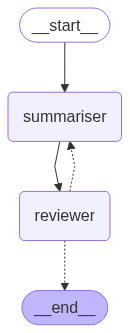

In [21]:

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)


##### Excecute the graph

In [22]:
output = graph.invoke({"summaries": summaries})

In [23]:
final_summary = output["created_summaries"][-1]

display(Markdown(final_summary))

<h1>🍏 Exciting Times in the Tech Sphere!</h1>

<p>Hey there, Tech Enthusiast!👋 Buckle up - we're diving into the latest waves shaking up the big companies and the trends defining our future. It's tech-tastic! 🚀</p>

<h2>✨ Big Company Moves</h2>
<h3>🌍 Key Highlights</h3>
<ul>
<li><strong>Go Global or Go Home:</strong> OpenAI is heading to New Delhi, marking India as its second-largest hub after the US. ChatGPT users, rejoice! 🇮🇳 <a href="https://dig.watch/updates/openai-to-open-office-in-new-delhi">Find out more</a></li>
<li><strong>AI Gets Agentic:</strong> Deutsche Bank lends insights into Agentic AI's evolutionary journey within enterprises. 🏢 <a href="https://www.linkedin.com/posts/lunguflorin_agentic-ai-in-the-enterprise-an-evolution-activity-7365236604690485249-BdOh">Discover the strategy</a> </li>
<li><strong>Learning Smarter:</strong> AI meets education with Canvas and OpenAI's powerful duo bringing personalized learning into classrooms. 🎓💡 <a href="https://mashable.com/article/open-ai-education-canvas-partnership">Read all about it</a> </li>
<li><strong>Real-time Innovation:</strong> Confluent's Streaming Agents bring the cutting edge of real-time AI automation right to your doorstep. ⚙️<a href="https://www.ainvest.com/news/confluent-streaming-agents-pioneering-real-time-ai-automation-enterprise-2508/">See how it works</a></li>
</ul>

<h3>🔍 Deeper Dive</h3>
<h4>1. The New Delhi Move</h4>
<p>With a bustling tech community and excellent infrastructure, India's capital is set to become a hotbed for AI advancements as OpenAI sets up shop. From strategic expansions to inclusive summits, all eyes are on New Delhi! 🏢<a href="https://dig.watch/updates/openai-to-open-office-in-new-delhi"> Learn more</a></p>

<h4>2. Agentic AI's Enterprise Affair</h4>
<p>Agentic AI, taking autonomy to a new level, promises an evolutionary shift in enterprise operations. Yet, it’s less about revolution, more about clever adaptation of traditional systems. 🔧 <a href="https://www.linkedin.com/posts/lunguflorin_agentic-ai-in-the-enterprise-an-evolution-activity-7365236604690485249-BdOh">Explore further</a></p>

<h2>🚀 Current Industry Trends</h2>
<h3>🌟 Key Highlights</h3>
<ul>
<li><strong>Automation Nation:</strong> AI Agents are reshaping workplaces by tackling the tedious, boosting creativity, and freeing up time. 🤖 <a href="https://denser.ai/blog/best-ai-agents/">Check it out</a></li>
<li><strong>GPT-5 Buzz:</strong> Anticipation builds as GPT-5 promises seamless integration of AI tools in everyday tech applications - the future is now! 💡 <a href="https://mashable.com/article/chatgpt-5-release-date">Learn more</a></li>
</ul>

<h3>📊 Deep Insights</h3>
<h4>1. The Rise of AI Agents</h4>
<p>These tech-savvy helpers are taking over mundane tasks, allowing humans to do what we do best - innovate! Think beyond bots; these are the next-gen workforce. 🤝🌟 <a href="https://denser.ai/blog/best-ai-agents/">Learn how they work</a></p>

<h4>2. Awaiting GPT-5</h4>
<p>Get ready for GPT-5, the latest in AI evolution, poised to revolutionize how AI tools are utilized across industries. Stay tuned for augmented efficiency! ⚡ <a href="https://mashable.com/article/chatgpt-5-release-date">Find out what's next</a></p>

<p>✨ Stay ahead with these insights and prepare for a future where tech and innovation go hand in hand. Until next time, happy reading! 🎉</p>


#### Send the email

In [24]:
def send_email(email_content: str):
    """Send email using Sendinblue API"""
    configuration = sib_api_v3_sdk.Configuration()
    configuration.api_key['api-key'] = os.getenv("SENDINBLUE_API_KEY")
    
    api_instance = sib_api_v3_sdk.TransactionalEmailsApi(sib_api_v3_sdk.ApiClient(configuration))
    
    email_params = {
        "subject": "Daily AI Research Summary",
        "sender": {"name": "Amal Thomas", "email": "reachthomas98@gmail.com"},
        "html_content": email_content,
        "to": [{"email": "reachthomas98@gmail.com", "name": "Amal Thomas"}],
        "params": {"subject": "Daily AI Research Summary"}
    }
    
    send_smtp_email = sib_api_v3_sdk.SendSmtpEmail(**email_params)
    
    try:
        api_response = api_instance.send_transac_email(send_smtp_email)
        print(api_response)
    except ApiException as e:
        print(f"Exception when calling SMTPApi->send_transac_email: {e}\n")

In [25]:
# from sib_api_v3_sdk.rest import ApiException

# def send_email(email_content: str):
#     """Send email using Brevo/Sendinblue Transactional API."""

#     api_key = os.getenv("SENDINBLUE_API_KEY")
#     if not api_key:
#         raise RuntimeError("SENDINBLUE_API_KEY is not set in environment variables.")

#     if not api_key.startswith("xkeysib-"):
#         print("Warning: API key does not look like a Brevo v3 key (usually starts with 'xkeysib-').")

#     configuration = sib_api_v3_sdk.Configuration()
#     configuration.api_key['api-key'] = api_key  # sets the Authorization header Brevo expects

#     api_instance = sib_api_v3_sdk.TransactionalEmailsApi(
#         sib_api_v3_sdk.ApiClient(configuration)
#     )

#     # make sure email_content is HTML-ish
#     if "<html" not in email_content.lower():
#         email_content = f"<!DOCTYPE html><html><body>{email_content}</body></html>"

#     email_params = {
#         "subject": "Daily AI Research Summary",
#         "sender": {"name": "Amal Thomas", "email": "reachthomas98@gmail.com"},
#         "html_content": email_content,
#         "to": [{"email": "reachthomas98@gmail.com", "name": "Amal Thomas"}],
#     }

#     try:
#         resp = api_instance.send_transac_email(sib_api_v3_sdk.SendSmtpEmail(**email_params))
#         print("Email sent. Response:", resp)
#         return resp
#     except ApiException as e:
#         # print server message body to see exact error
#         print("Brevo API error:", e)
#         if hasattr(e, 'body'):
#             print("Response body:", e.body)
#         raise


In [26]:
send_email(final_summary)

{'message_id': '<202508242133.92898483789@smtp-relay.mailin.fr>',
 'message_ids': None}
